In [1]:
#Importing required packages and files
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
import explore as e
from math import sqrt


#These imports were constructed
from wrangle import wrangle_zillow, train_validate, scale_zillow

#Tools to build machine learning models and reports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression


#Removes warnings and imporves asthenics
import warnings
#warnings.filterwarnings("ignore")

#Sets an option to show all columns
pd.options.display.max_columns = None
pd.options.display.width = 100
pd.options.display.max_colwidth = None
pd.options.display.max_rows = 200


1. Load your zillow dataset.

In [2]:
#Get data:
master_df = wrangle_zillow()

In [3]:
#Split data:
train, val, test = train_validate(master_df)

In [4]:
train_s, val_s, test_s = scale_zillow(train, val, test)

In [5]:
#Found schema on kaggle site
schema = pd.read_excel('zillow_data_dictionary.xlsx')
#schema
schema.loc[[4, 3, 11, 51, 50, 54, 17]]

,Feature,Description
4,'bedroomcnt',Number of bedrooms in home
3,'bathroomcnt',Number of bathrooms in home including fractional bathrooms
11,'calculatedfinishedsquarefeet',Calculated total finished living area of the home
51,'taxvaluedollarcnt',The total tax assessed value of the parcel
50,'yearbuilt',The Year the principal residence was built
54,'taxamount',The total property tax assessed for that assessment year
17,'fips',Federal Information Processing Standard code - see https://en.wikipedia.org/wiki/FIPS_county_code for more details


2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of taxvaluedollarcnt using only calculatedfinishedsqft.

    Here is some sample code to get you started:


`from sklearn.linear_model import LinearRegression`

`# assuming X and y are already defined`

`model = LinearRegression().fit(X, y)`

`predictions = model.predict(X)`

Modify and add to the code above as necessary for it to work with the zillow dataset.

In [6]:
train_s.head()

,bedrooms,bathrooms,sqft,tax_value,year_built,taxamount,fips
2045960,3.0,2.0,-0.455310,388527.0,1956.0,0.174617,6037.0
1345346,3.0,2.0,-0.447950,229705.0,1956.0,-0.147257,6037.0
761422,6.0,3.0,1.403785,251184.0,1951.0,-0.325879,6037.0
1667958,4.0,3.0,1.072555,525255.0,1990.0,0.576273,6059.0
564887,6.0,4.0,1.702419,174603.0,1972.0,-0.487893,6059.0


In [7]:
preds = train_s[['tax_value', 'sqft']]

In [8]:
model = LinearRegression().fit(train_s[['sqft']], train_s['tax_value'])

In [9]:
preds['yhat_baseline'] = train_s['tax_value'].mean()

In [10]:
preds['yhat'] = model.predict(train_s[['tax_value']])

In [11]:
preds['residual'] = preds['yhat'] - preds['tax_value']

In [12]:
preds['residual_baseline'] = preds['yhat_baseline'] - preds['tax_value']

In [13]:
preds.head()

,tax_value,sqft,yhat_baseline,yhat,residual,residual_baseline
2045960,388527.0,-0.455310,461274.212033,7.796413e+10,7.796374e+10,72747.212033
1345346,229705.0,-0.447950,461274.212033,4.609413e+10,4.609390e+10,231569.212033
761422,251184.0,1.403785,461274.212033,5.040421e+10,5.040396e+10,210090.212033
1667958,525255.0,1.072555,461274.212033,1.054006e+11,1.054001e+11,-63980.787967
564887,174603.0,1.702419,461274.212033,3.503710e+10,3.503692e+10,286671.212033


3. Plot the residuals for the linear regression model that you made.

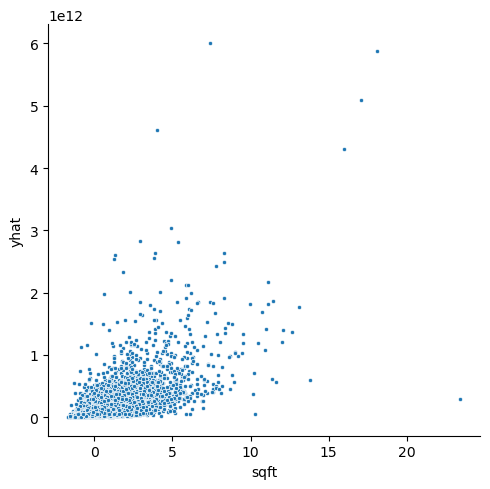

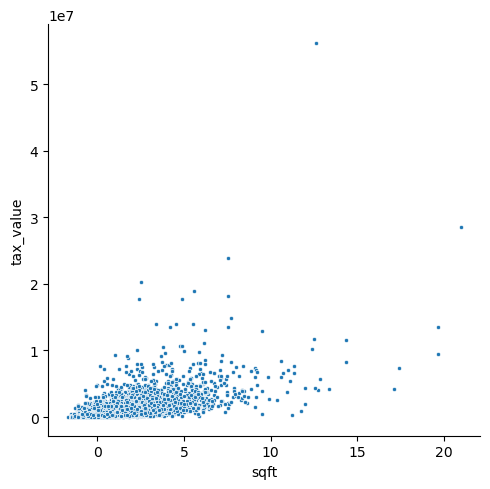

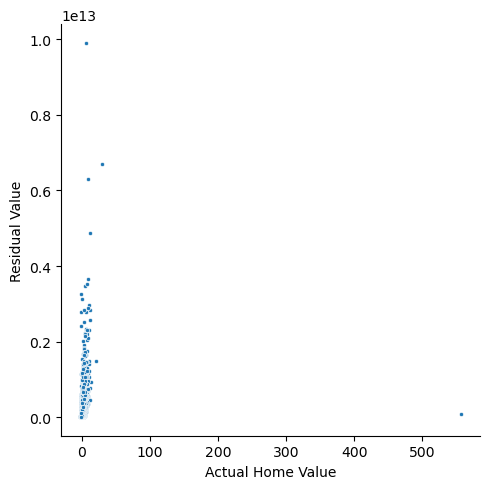

In [31]:
sns.relplot(data=preds.sample(50000), x='sqft', y='yhat', kind='scatter', marker='.')
sns.relplot(data=preds.sample(50000), x='sqft', y='tax_value', kind='scatter', marker='.')
sns.relplot(data=preds.sample(50000), x='sqft', y='residual', kind='scatter', marker='.')

plt.xlabel('Actual Home Value')
plt.ylabel('Residual Value')
plt.show()
#plt.xlim(left=0, right=8000)
#plt.ylim(top=500000, bottom =-800000)

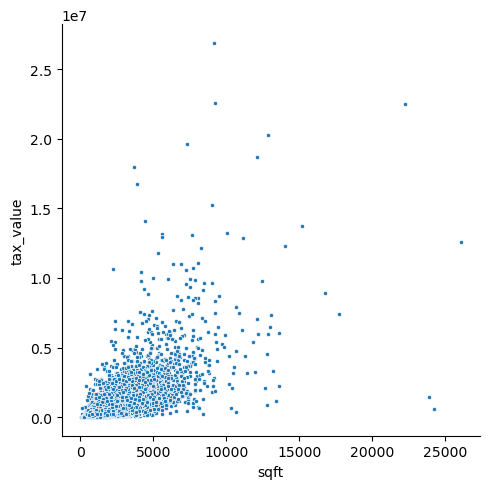

In [15]:
sns.relplot(data=train.sample(50000), x='sqft', y='tax_value', kind='scatter', marker='.')
#plt.ylim(top=1500000, bottom =0)

4. Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.

In [16]:
preds['residual^2'] = preds.residual ** 2

In [17]:
preds['residual_baseline^2'] = preds.residual_baseline ** 2

In [18]:
# SSE
SSE = sum(preds['residual^2'])
print("SSE = ", SSE)

SSE =  3.3195926506257526e+28


In [19]:
#ESS
ESS = ((preds.yhat - preds.tax_value.mean())**2)
ESS

2045960    6.078333e+21
1345346    2.124627e+21
761422     2.540538e+21
1667958    1.110920e+22
564887     1.227566e+21
               ...     
1471524    3.745775e+21
1663904    2.971370e+20
531072     2.125385e+21
1702801    1.016521e+23
934188     3.963169e+20
Name: yhat, Length: 1198531, dtype: float64

In [20]:
# MSE
MSE = SSE/len(preds)
print("MSE = ", MSE)

MSE =  2.769717805067831e+22


In [21]:
# RMSE
RMSE = sqrt(MSE)
print("RMSE = ", RMSE)

RMSE =  166424691829.90338


5. Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model (i.e. a model that always predicts the average taxvaluedollarcnt amount).

In [22]:
SSE_baseline = sum(preds['residual_baseline^2'])
MSE_baseline = SSE_baseline/len(preds)
RMSE_baseline = sqrt(MSE_baseline)

In [23]:
print("SSE - baseline = ", SSE_baseline)
print("MSE baseline = ", MSE_baseline)
print("RMSE baseline = ", RMSE_baseline)

SSE - baseline =  5.693976870710815e+17
MSE baseline =  475079649229.83344
RMSE baseline =  689260.218806971


6. Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.

In [24]:
if SSE < SSE_baseline:
    print('My OSL model performs better than baseline')
else:
    print('My OSL model performs worse than baseline.')


My OSL model performs worse than baseline.


7. What is the amount of variance explained in your model?

In [25]:
r2_score(preds.tax_value, preds.yhat)

-58300072619.61396

In [26]:
evs = explained_variance_score(preds.tax_value, preds.yhat)
evs

-40265987016.8002

8. Is your model better than the baseline model?

In [27]:
if RMSE < RMSE_baseline:
    print('My model RMSE performs better than baseline')
else:
    print('My model RMSE performs worse than baseline.')

My model RMSE performs worse than baseline.


9. Create a file named evaluate.py that contains the following functions.

- plot_residuals(y, yhat): creates a residual plot
- regression_errors(y, yhat): returns the following values:
    - sum of squared errors (SSE)
    - explained sum of squares (ESS)
    - total sum of squares (TSS)
    - mean squared error (MSE)
    - root mean squared error (RMSE)
- baseline_mean_errors(y): computes the SSE, MSE, and RMSE for the baseline model
- better_than_baseline(y, yhat): returns true if your model performs better than the baseline, otherwise false

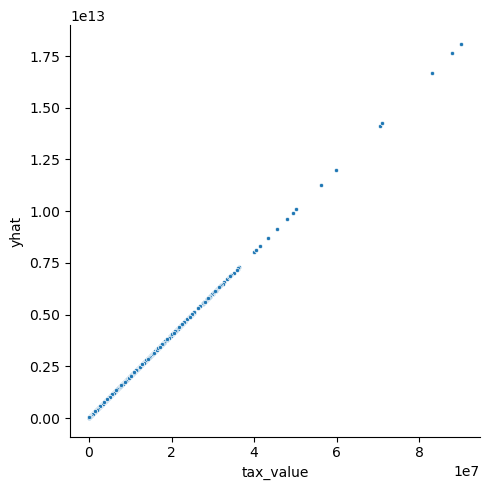

In [28]:
def plot_residuals(preds):
    sns.relplot(data = preds, x = 'tax_value', y = 'yhat', kind='scatter', marker='.')
plot_residuals(preds)